In [2]:
import gzip
import pickle
import matplotlib.pyplot as plt
import yaml
import io
import os
import numpy as np
np.seterr(all='warn')
import hist


from typing import Any, IO, Dict, List
import dctools
from dctools import plot as plotter
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy import stats as st

In [3]:
! python --version


Python 3.8.16


In [4]:
from cycler import cycler

def plotting(config, variable, channel, rebin=1, xlim=[], blind=False, era="someyear", checksyst=False):
    datasets:Dict = dict()
    color_cycle:List = []
    for name in config.groups:
        histograms = dict(
            filter(
                lambda _n: _n[0] in config.groups[name].processes,
                config.boosthist.items()
            )
        )
        p = dctools.datagroup(
            histograms = histograms,
            ptype      = config.groups[name].type,
            observable = variable,
            name       = name,
            xsections  = config.xsections,
            channel    = channel,
            luminosity = config.luminosity.value,
            rebin      = rebin
        )
        if 'gg' in p.name: continue
        datasets[p.name] = p
        if p.ptype == "signal":
            signal = p.name
            
        if hasattr(config.groups[name], "color") and len(p.to_boost().shape):
            color_cycle.append(config.groups[name].color)
            
    
    _plot_channel = plotter.add_process_axis(datasets)
    pred = _plot_channel.project('process', 'systematic', variable)[:hist.loc('data'),:,:]   
    data = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('data'),:]
    
    
    plt.figure(figsize=(6,7))
    ax, bx = plotter.mcplot(
        pred[{'systematic':'nominal'}].stack('process'),
        data=None if blind else data,
        syst=pred.stack('process'),
        colors = color_cycle
    )
    
    ymax = np.max([10000]+[c.get_height() for c in ax.containers[0] if ~np.isnan(c.get_height())])
    ymin = np.min([0.001]+[c.get_height() for c in ax.containers[0] if ~np.isnan(c.get_height())])
    
    ax.set_ylim(0.001, 1000*ymax)
    
    try:
        sig_ewk = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('VBSZZ2l2nu'),:]   
        sig_qcd = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('ZZ2l2nu'),:]   
        sig_ewk.plot(ax=ax, histtype='step', color='red')
        sig_qcd.plot(ax=ax, histtype='step', color='purple')
    except:
        pass
    bx.set_ylim([0.1, 1.9])
    if len(xlim) > 0:
        bx.set_xlim(xlim)
        
    ax.set_title(f"channel {channel}: {era}")
    ax.set_yscale('log')
    
    plt.savefig(f'plot-{channel}-{variable}-{era}.pdf')
    plt.savefig(f'plot-{channel}-{variable}-{era}.png')
    
    
    if checksyst:
        pred = _plot_channel.project('process','systematic', variable)[:hist.loc('data'),:,:]
        data = _plot_channel[{'systematic':'nominal'}].project('process',variable)[hist.loc('data'),:] 
        plotter.check_systematic(
            pred[{'systematic':'nominal'}].stack('process'),
            syst=pred.stack('process'),
            plot_file_name=f'check-sys-{channel}-{era}', 
            xrange=xlim
        )
    return _plot_channel, datasets

In [5]:
def systematic_check(config, variable, channel, rebin=1, xlim=[], blind=False, era="someyear") -> None:
    datasets:Dict = dict()
    color_cycle:List = []
    h_pred_tot = []
    for name in config.groups:
        histograms = dict(
            filter(
                lambda _n: _n[0] in config.groups[name].processes,
                config.boosthist.items()
            )
        )
        p = dctools.datagroup(
            histograms = histograms,
            ptype      = config.groups[name].type,
            observable = variable,
            name       = name,
            xsections  = config.xsections,
            channel    = channel,
            luminosity = config.luminosity.value,
            rebin      = rebin
        )
        if p.name == 'ggVV': continue
        datasets[p.name] = p
        if p.ptype == "signal":
            signal = p.name
            
        plt.figure(figsize=(5,5))
        plt.title(f"{channel} : {p.name}")
        if p.name != 'data':
            h_pred_tot.append(p.to_boost())
        try:
            p.to_boost()[{'systematic':'nominal'}].plot(label='nominal', color='black')
            p.to_boost()[{'systematic':'pileup_weightUp'}].plot(label='Up', color='red')
            p.to_boost()[{'systematic':'pileup_weightDown'}].plot(label='Down', color='blue')
            plt.legend()
            plt.yscale("log")
        except:
            print(f"{channel} : {p.name} : missing")
            pass
        plt.show()
        
    plt.figure(figsize=(5,5))
    plt.title(f"{channel} : {p.name} : total")
    print(" nominals  ------- ")
    print(np.round([hh[{'systematic':'nominal'}].values(0) for hh in h_pred_tot],5))
    print(" Ups       ------- ")
    print(np.round([hh[{'systematic':'JERUp'}].values(0) for hh in h_pred_tot],5))
    print(" Downs     ------- ")
    print(np.round([hh[{'systematic':'JERDown'}].values(0) for hh in h_pred_tot],5))
    
    print(" hnominals  ------- ")
    print(np.round([hh[{'systematic':'nominal'}].variances(0) for hh in h_pred_tot],5))
    print(" hUps       ------- ")
    print(np.round([hh[{'systematic':'JERUp'}].variances(0) for hh in h_pred_tot],5))
    print(" hDowns     ------- ")
    print(np.round([hh[{'systematic':'JERDown'}].variances(0) for hh in h_pred_tot],5))
    print(" Total     ------- ")
    h_tot = sum(h_pred_tot)
    print(" nom  ", np.round(h_tot[{'systematic':'nominal'}].values(0),5))
    print(" up   ", np.round(h_tot[{'systematic':'pileup_weightUp'}].values(0),5))
    print(" down ", np.round(h_tot[{'systematic':'pileup_weightDown'}].values(0),5))
    print(" ----------------- ")                    
    h_tot[{'systematic':'nominal'}].plot(label='nominal', color='black')
    h_tot[{'systematic':'pileup_weightUp'}].plot(label='Up', color='red')
    h_tot[{'systematic':'pileup_weightDown'}].plot(label='Down', color='blue')
    plt.legend()
    plt.ylim([0.001, 2e4])
    plt.yscale("log")
    plt.show()

In [6]:
#config_2016APV = dctools.read_config("config/input_UL_2016APV-amalfi.yaml")
#config_2016    = dctools.read_config("config/input_UL_2016-amalfi.yaml")
#config_2017    = dctools.read_config("config/input_UL_2017-amalfi.yaml")
#config_2018    = dctools.read_config("config/input_UL_2018-amalfi.yaml")
#config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")


In [7]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    print(channel)
    #if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    #if channel not in ['vbs-DY']: continue
    if channel not in ['photon_VBS_2']: continue
    for vname in ch_cfg:
        if 'met_pt' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2018"
        )

photon_VBS
vbs-DY
vbs-TT
vbs-NR
vbs-SR
photon_VBS_1


In [8]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    print(channel)
    #if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    #if channel not in ['vbs-DY']: continue
    if channel not in ['photon_VBS_2']: continue
    for vname in ch_cfg:
        #if 'dilep_m'  in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2018"
        )

photon_VBS
vbs-DY
vbs-TT
vbs-NR
vbs-SR
photon_VBS_1


photon_VBS
dict_items([('GJets', <dctools.datagroup object at 0x7fc64cac4e50>), ('data', <dctools.datagroup object at 0x7fc64cac4af0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fc64c64d5e0>), ('data', <dctools.datagroup object at 0x7fc64c662790>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fc27e5a47f0>), ('data', <dctools.datagroup object at 0x7fc27e615160>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fc64c400910>), ('data', <dctools.datagroup object at 0x7fc27e6ed130>)])
<class 'dctools.datagroup'>
(35, 5)
monika i am here
<cl

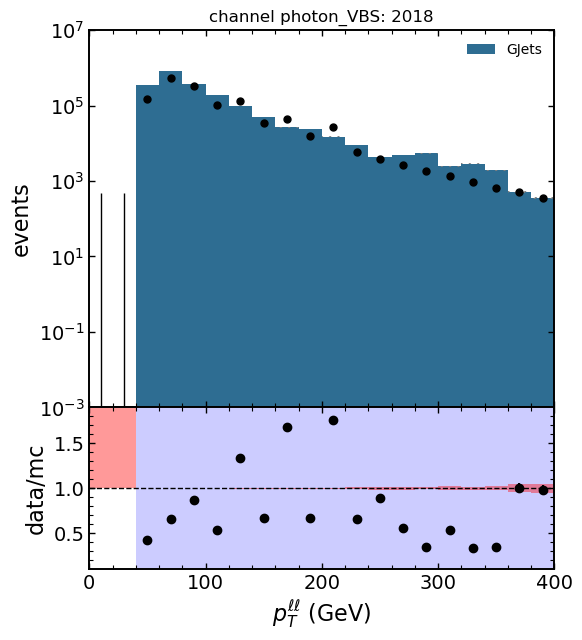

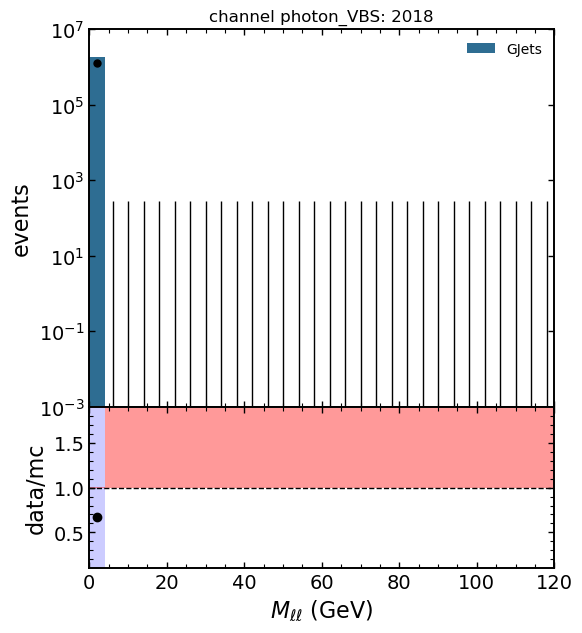

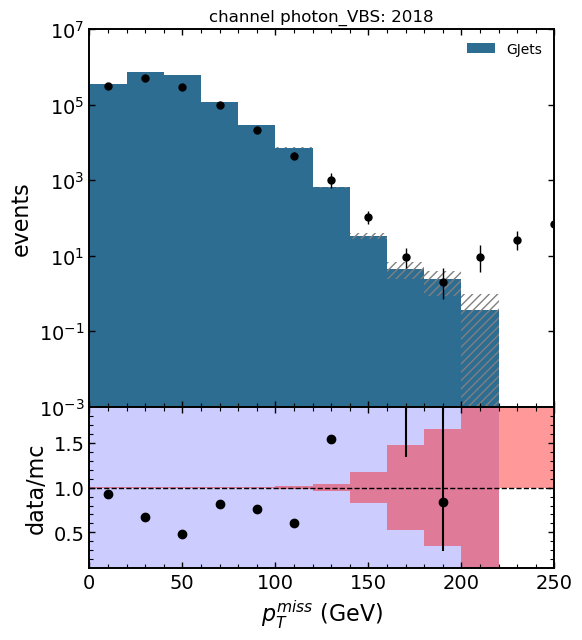

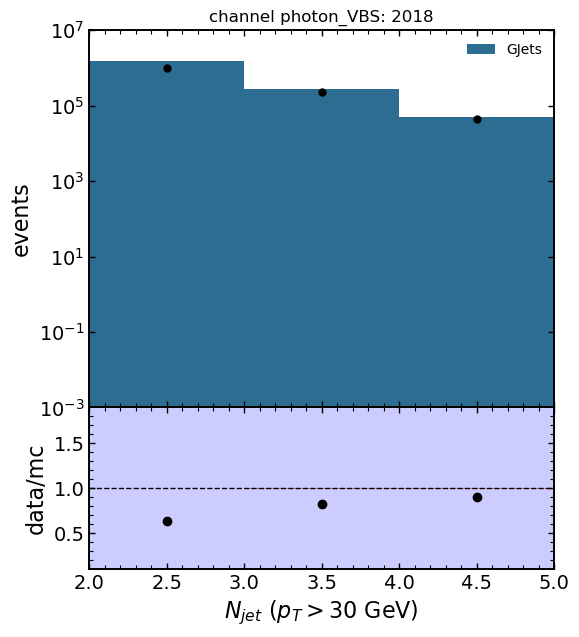

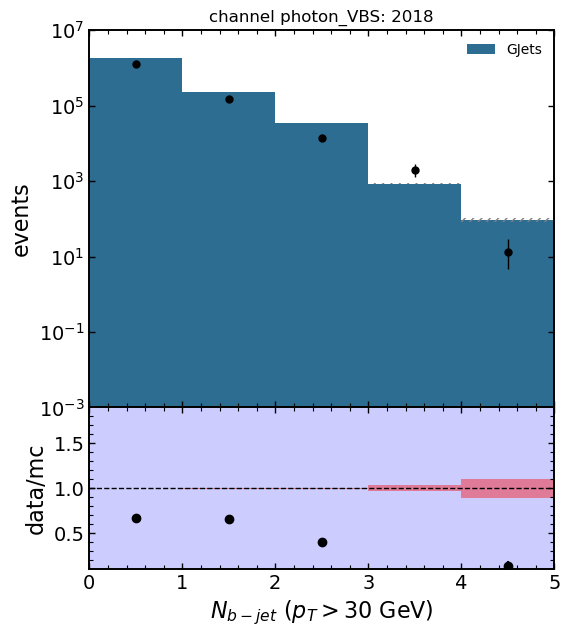

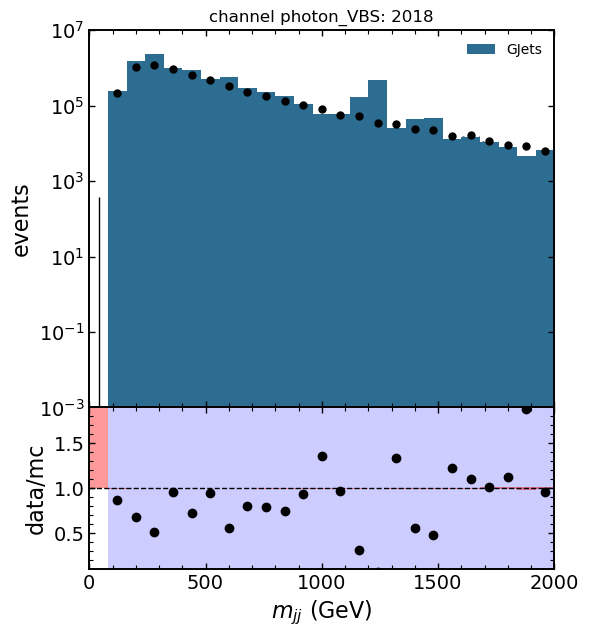

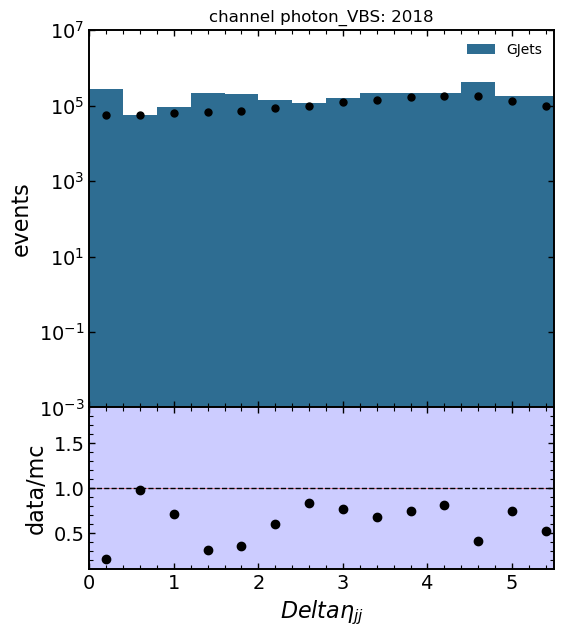

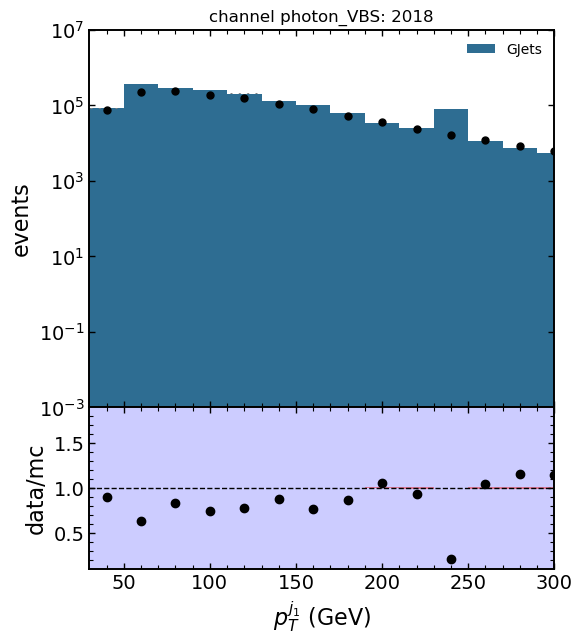

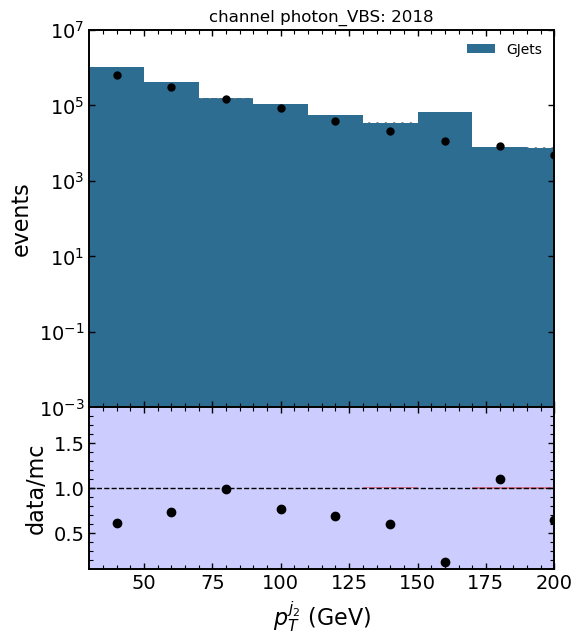

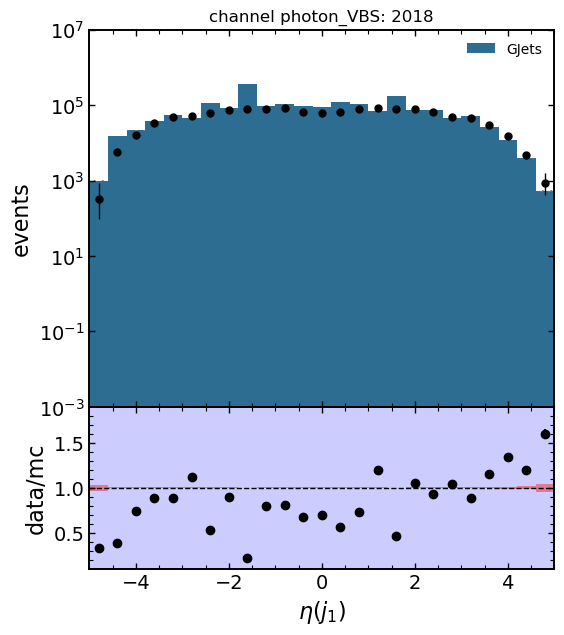

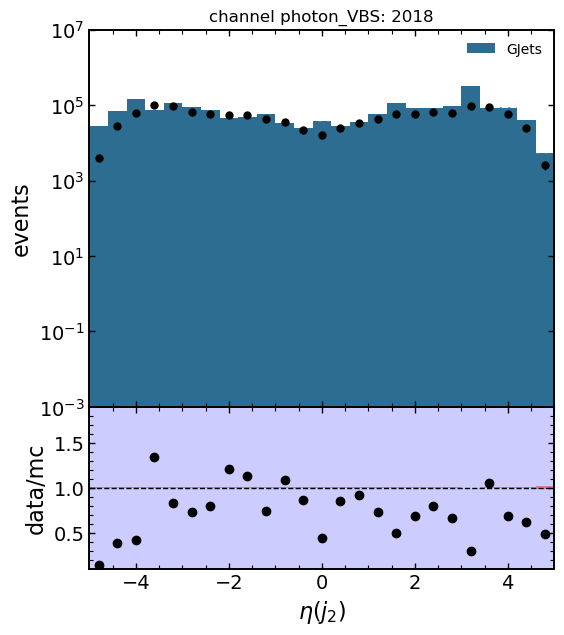

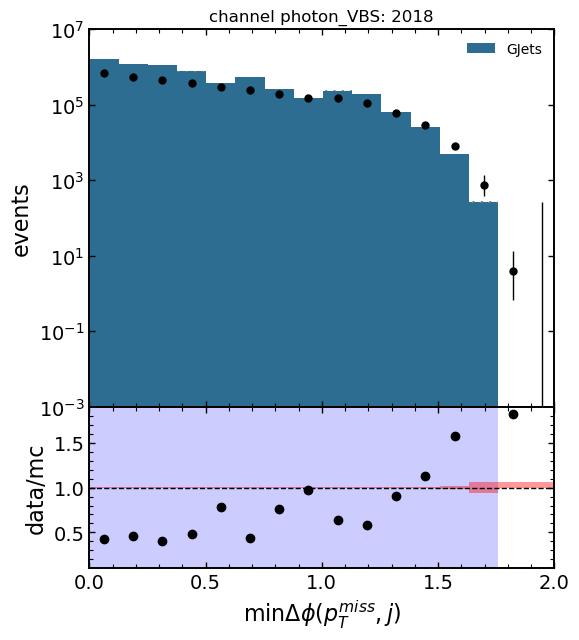

In [9]:
config_2018 = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    print(channel)
    #if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    #if channel not in ['vbs-DY']: continue
    if channel not in ['photon_VBS']: continue
    for vname in ch_cfg:
        if 'dilep_mass'  in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2018"
        )

vbs-DY
[WARNING] : WW: met_pt: vbs-DY not present in axes. available channels:
['cat-EM', 'cat-TT', 'cat-NR', 'vbs-EM', 'vbs-TT', 'vbs-NR', 'vbs-3L', 'cat-3L', 'cat-SR1J', 'cat-DY', 'cat-SR0J', 'cat-SR2J']
[WARNING] : VVV: met_pt: vbs-DY not present in axes. available channels:
['cat-SR1J', 'cat-SR2J', 'cat-DY', 'cat-3L', 'cat-EM', 'cat-TT', 'cat-NR', 'vbs-TT', 'vbs-NR', 'vbs-EM', 'cat-SR0J', 'vbs-SR', 'vbs-SR0', 'vbs-3L']
dict_items([('WW', <dctools.datagroup object at 0x7f2445411430>), ('WZ', <dctools.datagroup object at 0x7f2445481640>), ('DY', <dctools.datagroup object at 0x7f24452263a0>), ('TOP', <dctools.datagroup object at 0x7f2444f9ea30>), ('VVV', <dctools.datagroup object at 0x7f244522c460>), ('ZZ2l2nu', <dctools.datagroup object at 0x7f24454b1a30>), ('VBSZZ2l2nu', <dctools.datagroup object at 0x7f243bf62100>), ('data', <dctools.datagroup object at 0x7f243bf629d0>)])
<class 'dctools.datagroup'>
(43, 30)
monika i am here
<class 'dctools.datagroup'>
(43, 30)
monika i am here
<cl

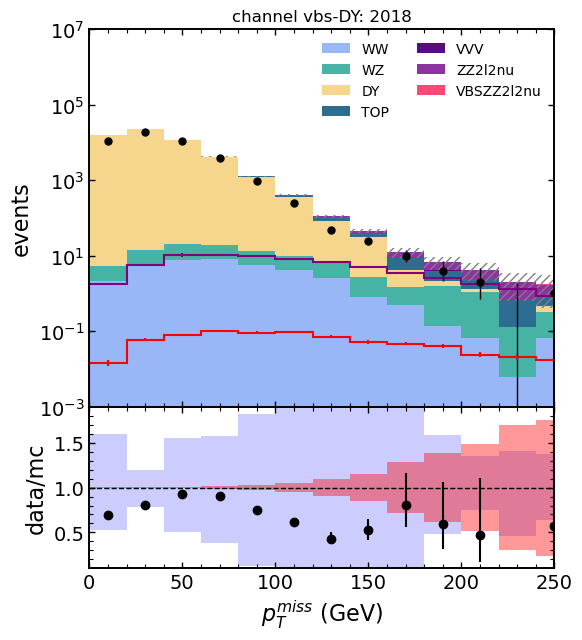

In [7]:
#for plotting

config_2018    = dctools.read_config("config/input_UL_2018-amalfi.yaml")
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    print(channel)
    #if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    if channel not in ['vbs-DY']: continue
    #if channel not in ['Photon_CR']: continue
    for vname in ch_cfg:
        if 'met_pt' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2018"
        )

In [11]:
 for channel in config_2018.plotting:
     ch_cfg = config_2018.plotting[channel]
     if channel not in ['Photon']: continue
     for vname in ch_cfg:
         #if 'gnn_flat' not in vname: continue
         v_cfg = ch_cfg[vname]
         systematic_check(
             config_2018, vname, channel, 
             rebin=v_cfg.rebin, 
             xlim=v_cfg.range, 
             blind=v_cfg.blind,
             era="2018"
         )

In [44]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7187.61, variance=12484.2) (WeightedSum(value=7291.54, variance=12663.8) with flow)

In [45]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7128.39, variance=12385.8) (WeightedSum(value=7232.32, variance=12565.4) with flow)

In [46]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7184.57, variance=12466.7) (WeightedSum(value=7288.51, variance=12646.3) with flow)

In [47]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7129.33, variance=12379.5) (WeightedSum(value=7233.27, variance=12559.1) with flow)

In [5]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'pileup_weightUp', 'PhotonSFUp', 'PhotonSFDown', 'pileup_weightDown', 'kEWUp', 'kEWDown'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=16838.9, variance=23033.9) (WeightedSum(value=17088.3, variance=23376.9) with flow)

In [6]:
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'pileup_weightDown', 'PhotonSFDown', 'PhotonSFUp', 'pileup_weightUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=12007.7, variance=17987.4) (WeightedSum(value=12180.2, variance=18246.3) with flow)

In [7]:
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'pileup_weightDown', 'UEPS_ISRUp', 'QCDScale0wUp', 'kEWDown', 'UEPS_FSRUp', 'aS_weightDown', 'UEPS_FSRDown', 'QCDScale0wDown', 'QCDScale1wUp', 'UEPS_ISRDown', 'aS_weightUp', 'PhotonSFUp', 'PDF_weightUp', 'QCDScale2wUp', 'kEWUp', 'pileup_weightUp', 'QCDScale2wDown', 'PDF_weightDown', 'QCDScale1wDown'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=50626.6, variance=62237.6) (WeightedSum(value=51370.9, variance=63120.5) with flow)

In [8]:
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1


Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'aS_weightUp', 'UEPS_FSRUp', 'UEPS_FSRDown', 'QCDScale1wDown', 'UEPS_ISRDown', 'PhotonSFUp', 'QCDScale0wDown', 'UEPS_ISRUp', 'PhotonSFDown', 'kEWUp', 'QCDScale2wUp', 'PDF_weightUp', 'kEWDown', 'QCDScale2wDown', 'aS_weightDown', 'PDF_weightDown', 'QCDScale0wUp', 'QCDScale1wUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=45812.9, variance=56044.4) (WeightedSum(value=46469.7, variance=56810.4) with flow)

In [9]:
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1


Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7129.91, variance=12385.4) (WeightedSum(value=7233.84, variance=12565) with flow)

In [10]:
#adding keW( just see that its 1 always why 7129 --> 11906)
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1


Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'kEWDown', 'kEWUp', 'PhotonSFUp', 'PhotonSFDown'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=11906.5, variance=17280.5) (WeightedSum(value=12079.7, variance=17530.7) with flow)

In [11]:
#adding keW( just see that its 1 always why 7129 --> 11906 (7139))
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1


Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'PhotonSFDown', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7139, variance=12401) (WeightedSum(value=7242.93, variance=12580.6) with flow)

In [17]:
#adding keW( just see that its 1 always why 7129 --> 11906 (7139))
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1


Hist(
  StrCategory(['photon_VBS', 'photon_VBS_1'], growth=True, name='channel'),
  StrCategory(['nominal', 'pileup_weightUp', 'pileup_weightDown', 'kEWDown', 'PhotonSFDown', 'kEWUp', 'PhotonSFUp'], growth=True, name='systematic'),
  Regular(60, 0, 600, name='dilep_pt', label='$p_{T}^{\\ell\\ell}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=16885.3, variance=23089.7) (WeightedSum(value=17126.4, variance=23420.1) with flow)

In [29]:
#adding keW( just see that its 1 always why 7129 --> 11906 (7139))
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/nput_UL_2017-PhotonCR.yaml")

#h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["dilep_pt"]
h1=config_2018.boosthist["SinglePhoton"]["hist"]["lead_jet_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_2', 'photon_VBS_1', 'photon_VBS_3'], growth=True, name='channel'),
  StrCategory(['nominal'], growth=True, name='systematic'),
  Regular(50, 30, 530, name='lead_jet_pt', label='$p_T^{j_1}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=206143, variance=1.25353e+07) (WeightedSum(value=206279, variance=1.25362e+07) with flow)

In [26]:
#adding keW( just see that its 1 always why 7129 --> 11906 (7139))
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
config_2018    = dctools.read_config("config/input_UL_2017-PhotonCR.yaml")

h1=config_2018.boosthist["GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["lead_jet_pt"]
#h1=config_2018.boosthist["EGamma"]["hist"]["met_pt"]
#boosthist["DYJetsToLL_histogram_8.pkl.gz0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
h1

Hist(
  StrCategory(['photon_VBS', 'photon_VBS_2', 'photon_VBS_1', 'photon_VBS_3'], growth=True, name='channel'),
  StrCategory(['nominal', 'btag_sf_statUp', 'PDF_weightUp', 'btag_sf_bc_correlatedDown', 'UEPS_FSRUp', 'QCDScale1wUp', 'aS_weightDown', 'UEPS_ISRUp', 'btag_sf_light_correlatedUp', 'kEWUp', 'QCDScale0wUp', 'pileup_weightDown', 'PhotonSFDown', 'btag_sf_light_2018Down', 'pileup_weightUp', 'kEWDown', 'QCDScale2wDown', 'btag_sf_bc_2018Up', 'btag_sf_light_correlatedDown', 'btag_sf_bc_correlatedUp', 'btag_sf_bc_2018Down', 'prefiring_weightDown', 'btag_sf_light_2018Up', 'UEPS_ISRDown', 'UEPS_FSRDown', 'PhotonSFUp', 'QCDScale2wUp', 'PDF_weightDown', 'btag_sf_statDown', 'QCDScale0wDown', 'prefiring_weightUp', 'QCDScale1wDown', 'aS_weightUp', 'gnnloDown', 'gnnloUp'], growth=True, name='systematic'),
  Regular(50, 30, 530, name='lead_jet_pt', label='$p_T^{j_1}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=6.05784e+08, variance=9.77344e+16)

In [30]:
(h1[{"channel":"photon_VBS", 
     "systematic":h1.axes['systematic'].value(0), 
     #"lead_jet_pt": hist.rebin(2)
    }]*1).show( )

  0.300 _ x 10^+02                                                   1202/row ╷
  0.400 _██████
  0.500 _███████████████████████████████
  0.600 _█████████████████████████████████████████████████████████████████
  0.700 _██████████████████████████████████████████████
  0.800 _██████████████████████████████████████████████████
  0.900 _██████████████████████████████████████████████████████████████████████
  1.000 _█████████████████████████
  1.100 _████████████████████████
  1.200 _██████████████████████████
  1.300 _███████████████████████
  1.400 _█████████████████████████████████
  1.500 _██████████████
  1.600 _█████████████
  1.700 _█████
  1.800 _██████
  1.900 _██████
  2.000 _████
  2.100 _███████████
  2.200 _███
  2.300 _██
  2.400 _█████
  2.500 _█
  2.600 _
  2.700 _█
  2.800 _█
  2.900 _
  3.000 _
  3.100 _
  3.200 _
  3.300 _█
  3.400 _
  3.500 _
  3.600 _
  3.700 _
  3.800 _
  3.900 _
  4.000 _
  4.100 _
  4.200 _
  4.300 _
  4.400 _
  4.500 _
  4.600 _
  4.700 _
  4.800 

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:33: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff37146e9d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

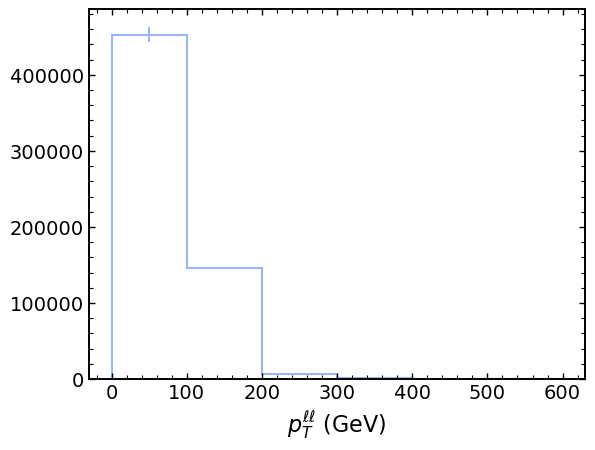

In [33]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR_1.yaml")

#h1=config_2018.boosthist["GJets_HT-40To100_TuneCP5_13TeV-madgraphMLM-pythia8"]["hist"]["met_pt"]
h2=config_2018.boosthist["EGamma"]["hist"]["dilep_pt"]
#boosthist["DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8"]["hist"]["dilep_mt"].axes["systematic"]
(h2[{"channel":"photon_VBS", 
     "systematic":h2.axes['systematic'].value(0), 
     "dilep_pt": hist.rebin(10)
    }]*1).plot()
(h1[{"channel":"photon_VBS", 
     "systematic":h1.axes['systematic'].value(0), 
     "dilep_pt": hist.rebin(10)
    }]*1).plot()
#plt.stairs(h1.axes['systematic'].value(0),h1.axes['systematic'].edges);
#plt.stairs(h2.axes['systematic'].value(0),h2.axes['systematic'].edges);

ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 1` and `len(edges) = 8`.

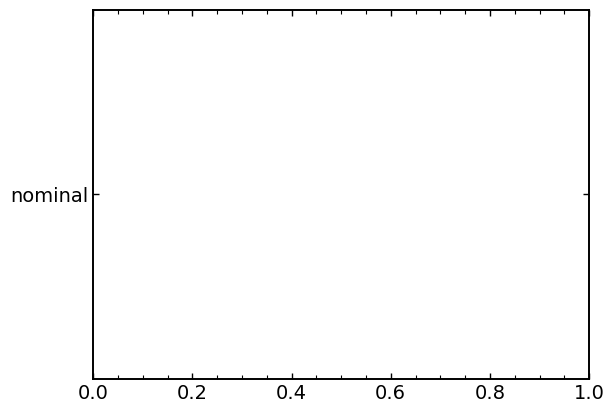

In [36]:
plt.stairs(h2.axes['systematic'].value(0));

In [24]:
(h1[{"channel":"photon_VBS", 
     "systematic":h1.axes['systematic'].value(0), 
     #"met_pt": hist.rebin(2)
    }]*1).show( )

  0.000 _ x 10^+02                                                      7/row ╷
  0.100 _
  0.200 _
  0.300 _
  0.400 _
  0.500 _
  0.600 _██████████
  0.700 _██████████████████████████████
  0.800 _██████████
  0.900 _████████████████████████████████████████
  1.000 _████████████████████████████████████████████████████████████
  1.100 _████████████████████████████████████████
  1.200 _
  1.300 _██████████████████████████████████████████████████
  1.400 _████████████████████████████████████████████████████████████
  1.500 _██████████████████████████████
  1.600 _██████████████████████████████████████████████████████████████████████
  1.700 _████████████████████
  1.800 _████████████████████
  1.900 _██████████████████████████████████████████████████████████████████████
  2.000 _██████████
  2.100 _
  2.200 _████████████████████
  2.300 _██████████
  2.400 _
  2.500 _██████████
  2.600 _
  2.700 _██████████
  2.800 _
  2.900 _██████████
  3.000 _
  3.100 _
  3.200 _██████████
  3.300 _█

In [16]:
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    #if channel not in ['vbs-SR']: continue
    for vname in ch_cfg:
        if 'met_pt' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2018"
        )

dict_items([('WJets', <dctools.datagroup object at 0x7fd7ab866b80>), ('ZGamma', <dctools.datagroup object at 0x7fd7ab8668b0>), ('WW', <dctools.datagroup object at 0x7fd7ab866370>), ('GJets', <dctools.datagroup object at 0x7fd7ab866be0>), ('data', <dctools.datagroup object at 0x7fd7ab8662e0>)])


UnboundLocalError: local variable 'axes' referenced before assignment

In [8]:
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    # if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    if channel not in ['vbs-SR']: continue
    for vname in ch_cfg:
        if 'gnn_flat' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2018"
        )
        plotting(
            config_2017, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2017"
        )
        plotting(
            config_2016, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2016"
        )
        plotting(
            config_2016APV, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2016APV"
        )

TypeError: make_split() missing 1 required positional argument: 'gap'

<Figure size 600x700 with 0 Axes>

WW (43, 7)
WZ (43, 7)
DY (43, 7)
Top (43, 7)
VVV (43, 7)
ZZ2l2nu (43, 7)
ekw_ZZ2l2nu (43, 7)
data (1, 7)
WW (43, 7)
WZ (43, 7)
DY (43, 7)
Top (43, 7)
VVV (43, 7)
ZZ2l2nu (43, 7)
ekw_ZZ2l2nu (43, 7)
data (1, 7)
WW (43, 7)
WZ (43, 7)
DY (43, 7)
Top (43, 7)
VVV (43, 7)
ZZ2l2nu (43, 7)
ekw_ZZ2l2nu (43, 7)
data (1, 7)
WW (43, 7)
WZ (43, 7)
DY (43, 7)
Top (43, 7)
VVV (43, 7)
ZZ2l2nu (43, 7)
ekw_ZZ2l2nu (43, 7)
data (1, 7)
WZ (43, 7)
DY (43, 7)
Top (43, 7)
VVV (43, 7)
ZZ2l2nu (43, 7)
ekw_ZZ2l2nu (43, 7)
data (1, 7)


UnboundLocalError: local variable 'axes' referenced before assignment

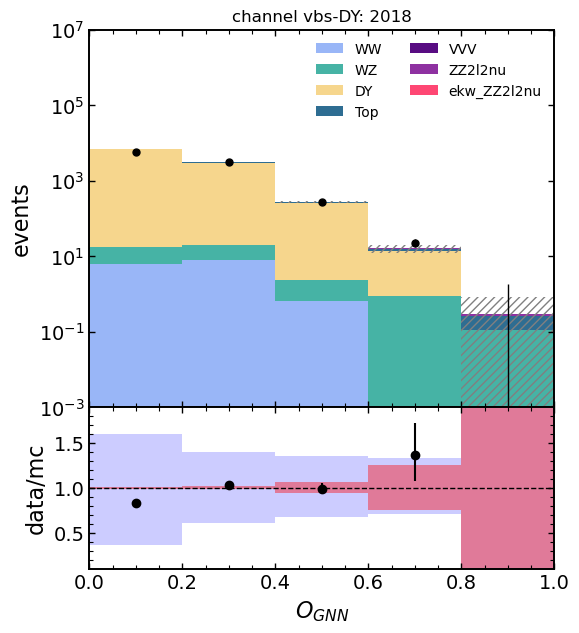

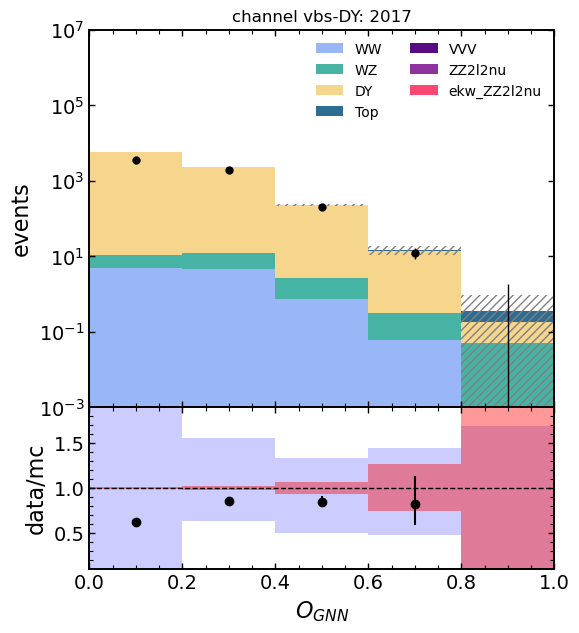

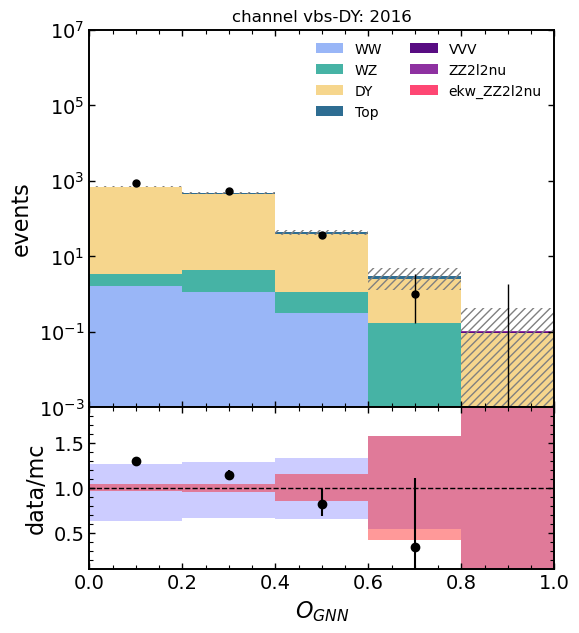

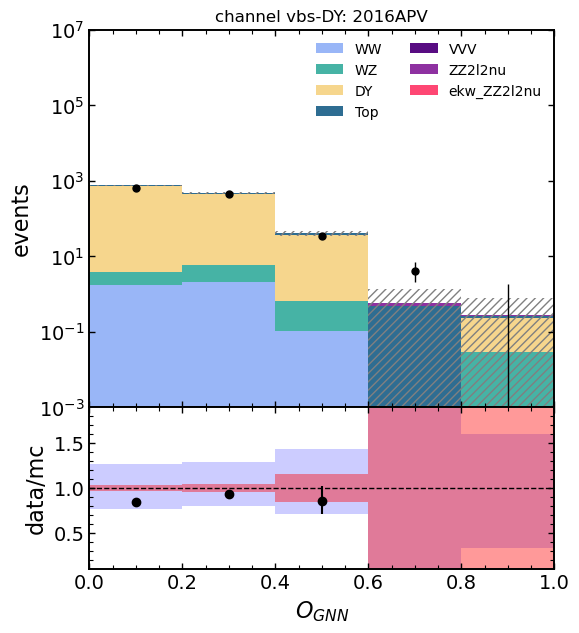

In [7]:
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    if channel not in ['vbs-SR', 'vbs-TT', 'vbs-DY', 'vbs-EM', 'vbs-3L']: continue
    #if channel not in ['vbs-SR']: continue
    for vname in ch_cfg:
        if 'gnn_score' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2018"
        )
        plotting(
            config_2017, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2017"
        )
        plotting(
            config_2016, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2016"
        )
        plotting(
            config_2016APV, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2016APV"
        )

## Additional checks

In [22]:
xsec_ = None
with open("config/xsections_2018.yaml", 'r') as fn_:
    xsec_ = yaml.full_load(fn_)
    
lumi = 60.0

In [71]:
h.axes['systematic']

StrCategory(['nominal', 'aS_weightUp', 'btag_sf_light_2018Up', 'btag_sf_light_correlatedDown', 'UEPS_FSRUp', 'pileup_weightDown', 'triggerSFUp', 'kEWUp', 'aS_weightDown', 'PDF_weightDown', 'PDF_weightUp', 'pileup_weightUp', 'QCDScale2wUp', 'btag_sf_light_correlatedUp', 'btag_sf_light_2018Down', 'QCDScale0wDown', 'LeptonSFDown', 'QCDScale2wDown', 'btag_sf_statUp', 'btag_sf_bc_correlatedDown', 'triggerSFDown', 'btag_sf_bc_2018Up', 'btag_sf_bc_correlatedUp', 'QCDScale1wUp', 'btag_sf_bc_2018Down', 'btag_sf_statDown', 'kEWDown', 'QCDScale0wUp', 'LeptonSFUp', 'QCDScale1wDown', 'UEPS_ISRUp', 'UEPS_ISRDown', 'UEPS_FSRDown', 'JESUp', 'JESDown', 'JERUp', 'JERDown', 'UESUp', 'UESDown', 'ElectronEnUp', 'ElectronEnDown', 'MuonRocUp', 'MuonRocDown'], growth=True, name='systematic', label='systematic')

-----------------------------------------
DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8 504833804689.0127 5129 0.0006095867533862431
[12.0, 4.0, 11.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[7.0, 19.0, 4.0, 11.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, 11.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8 423239418874.17444 951.5 0.00013488819201165283
[3266.0, 5568.0, 3731.0, 1633.0, 544.0, 182.0, 32.0, 12.0, 3.0, 0.0] nominal
[4850.0, 6452.0, 5211.0, 674.0, 534.0, 181.0, 33.0, 6.0, 4.0, 1.0] JERUp
[2806.0, 4830.0, 3139.0, 1335.0, 407.0, 152.0, 24.0, 8.0, 1.0, 0.0] JERDown
-----------------------------------------
DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8 113668413845.139 361.4 0.00019076539617718356
[7852.0, 12271.0, 6072.0, 2024.0, 513.0, 185.0, 40.0, 11.0, 0.0, -0.0] nominal
[8100.0, 11914.0, 5785.0, 1824.0, 558.0, 180.0, 54.0, 21.0, 6.0, -1.0] JERUp
[7909.0, 11830.0, 5954.0, 

/var/folders/r9/chm6z6j53wz271dgtjskvny00000gn/T/ipykernel_60620/591243275.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5))
/opt/homebrew/Caskroom/mambaforge/base/envs/hep310/lib/python3.10/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8 845232.0 1.608 0.00011414617525129195
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8 493998.0 1.626 0.0001974906780999113
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
GluGluToWWToENEN_TuneCP5_13TeV_MCFM701_pythia8 4904000.0 36.8 0.0004502446982055465
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
----------------------

/opt/homebrew/Caskroom/mambaforge/base/envs/hep310/lib/python3.10/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/hep310/lib/python3.10/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/hep310/lib/python3.10/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/var/folders/r9/chm6z6j53wz271dgtjskvny00000gn/T/ipykernel_60620/591243275.py:51: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/opt/homebrew/Caskroom/mambaforge/base/envs/hep310/lib/python3.10/site-packages/numpy/ma/core.py:6900: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


[6.0, 21.0, 29.0, 35.0, 31.0, 21.0, 14.0, 8.0, 5.0, 2.0] nominal
[7.0, 21.0, 59.0, 37.0, 32.0, 21.0, 13.0, 8.0, 5.0, 2.0] JERUp
[7.0, 20.0, 30.0, 34.0, 31.0, 20.0, 13.0, 8.0, 5.0, 2.0] JERDown
-----------------------------------------
TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8 3502613.3919518394 0.218156891833184 0.003737042044111221
[-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
TTWJetsToQQ_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8 656374.2728368 0.44036756760757 0.04025455467999999
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] nominal
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERUp
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] JERDown
-----------------------------------------
TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8 4782962.671003081 0.2432 0.003050828744381518
[0.0, 0.0, 0

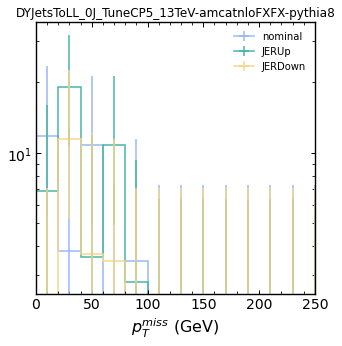

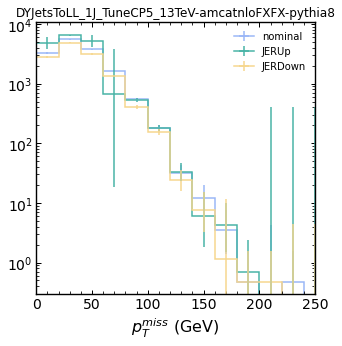

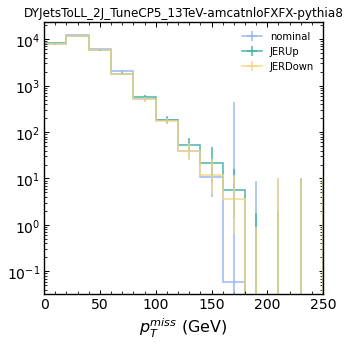

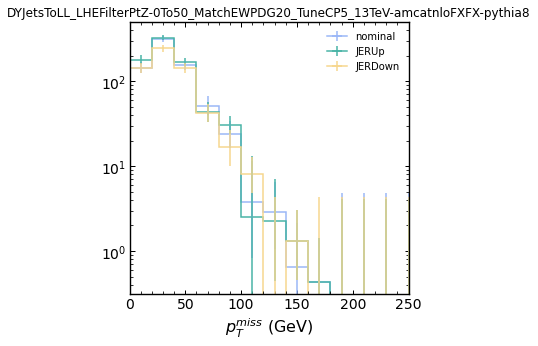

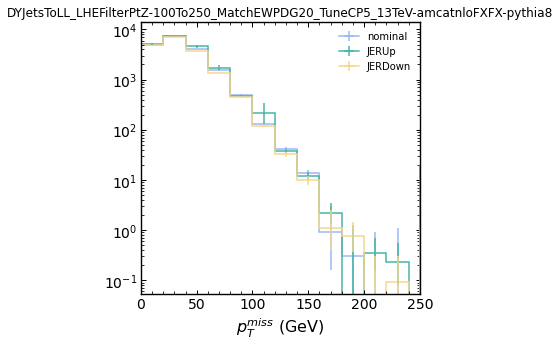

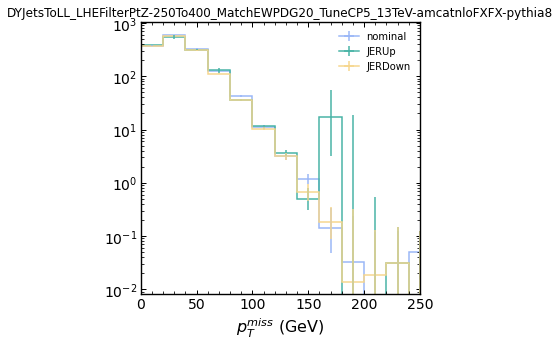

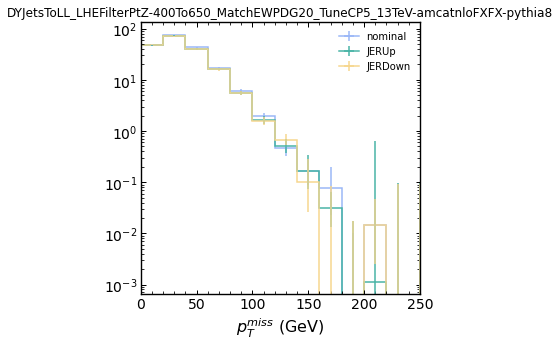

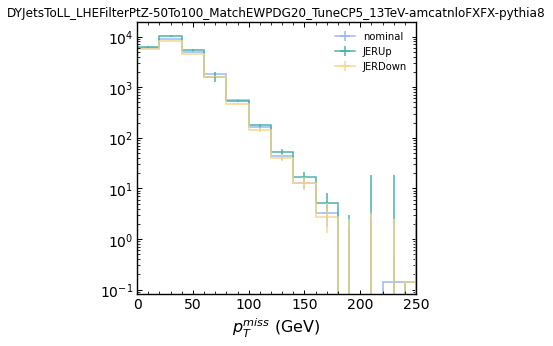

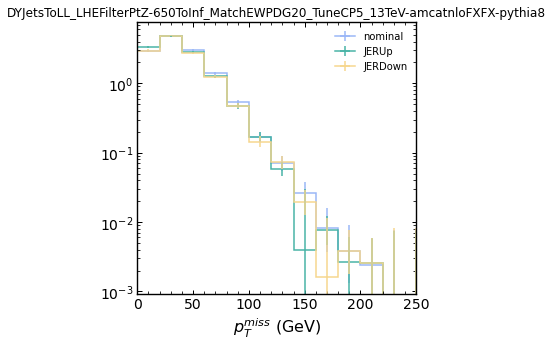

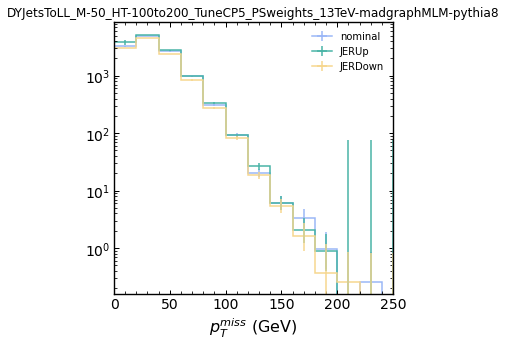

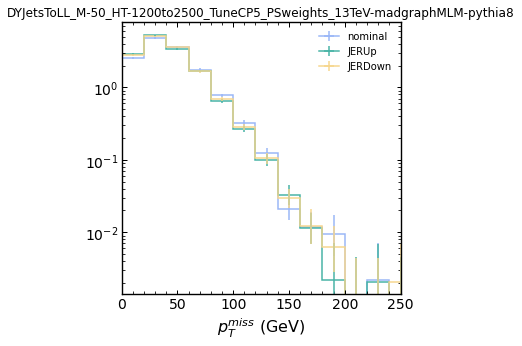

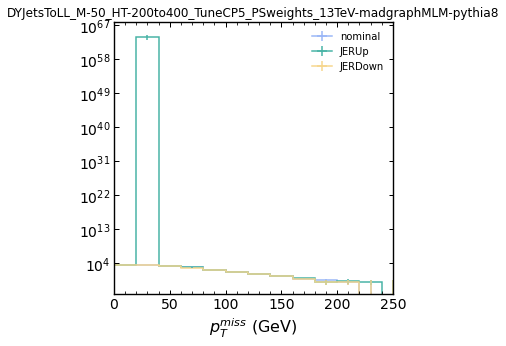

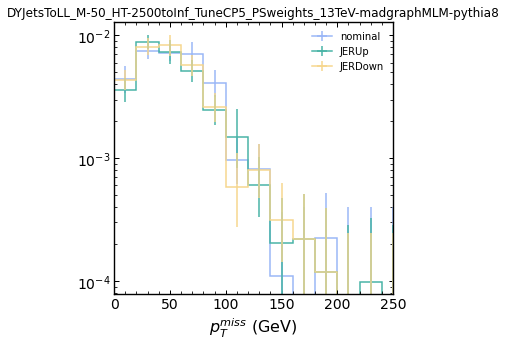

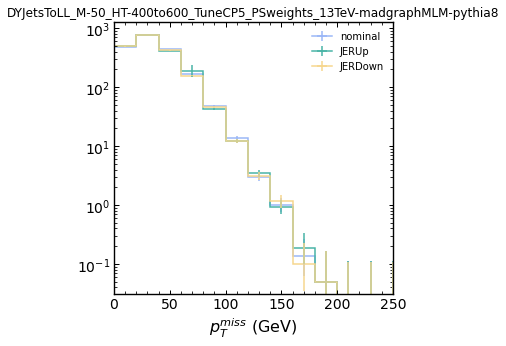

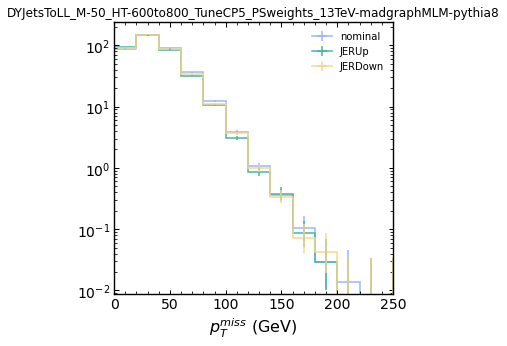

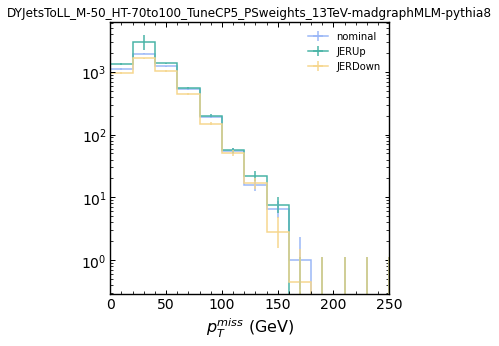

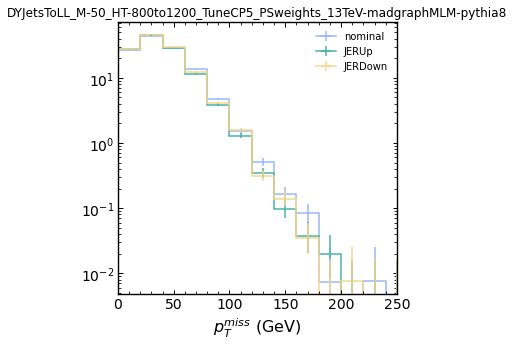

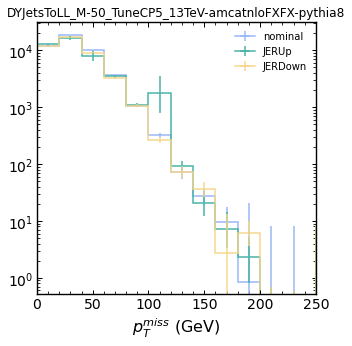

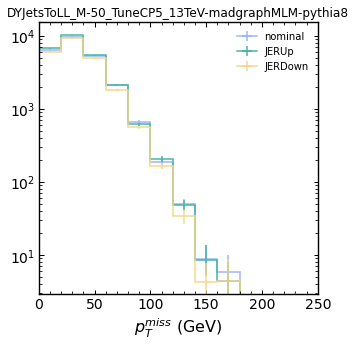

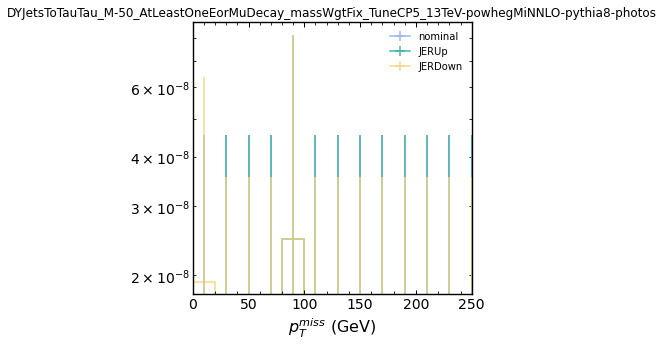

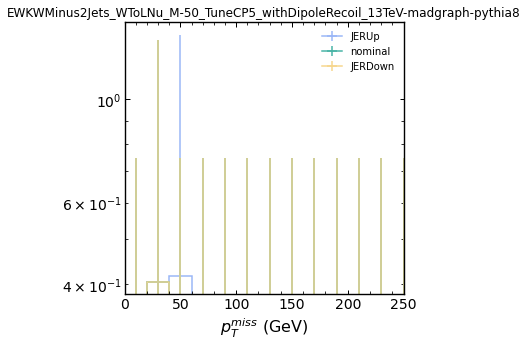

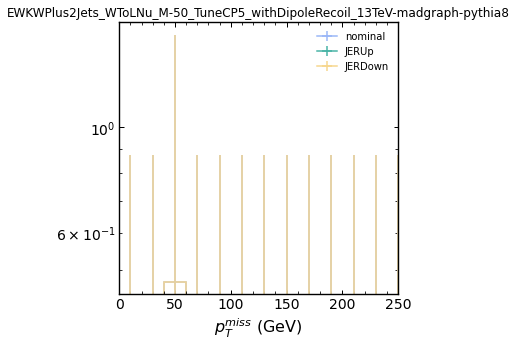

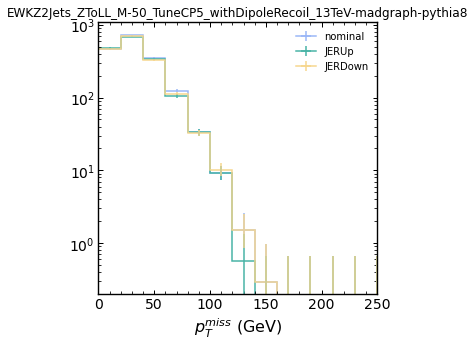

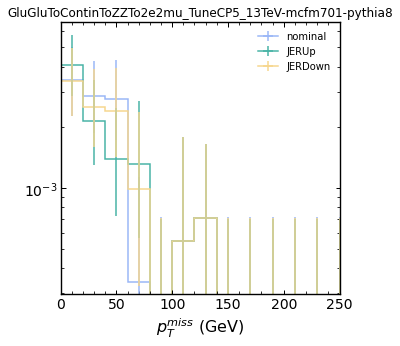

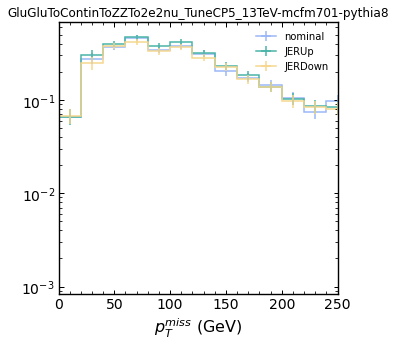

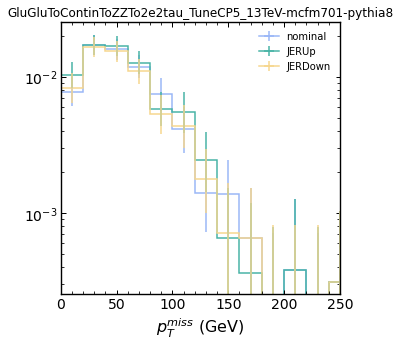

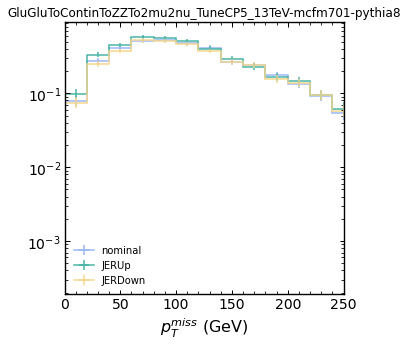

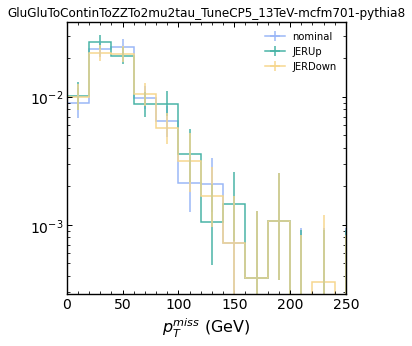

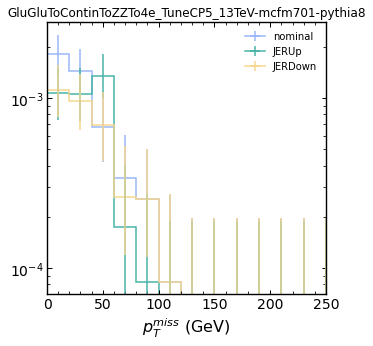

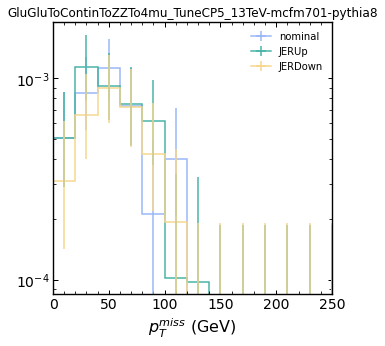

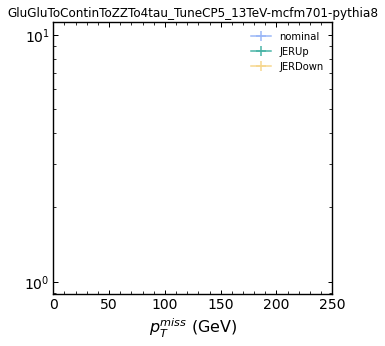

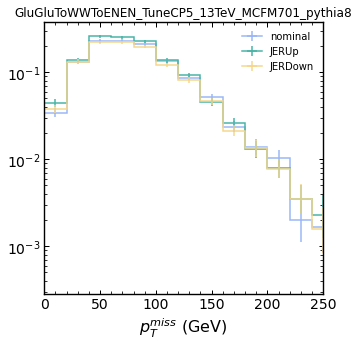

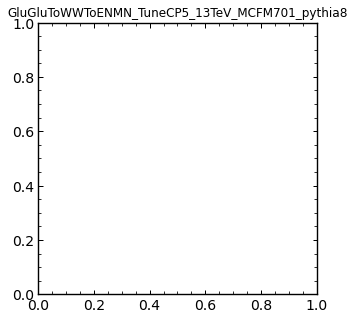

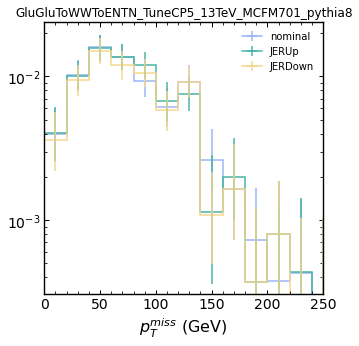

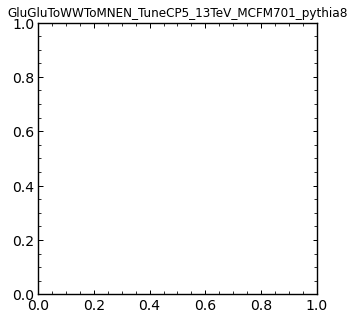

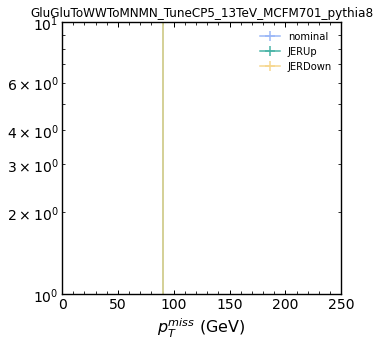

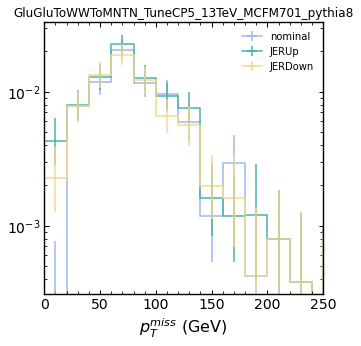

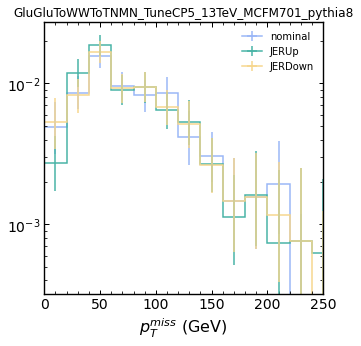

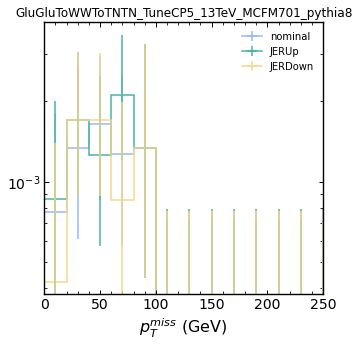

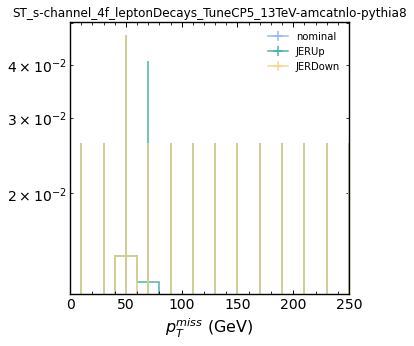

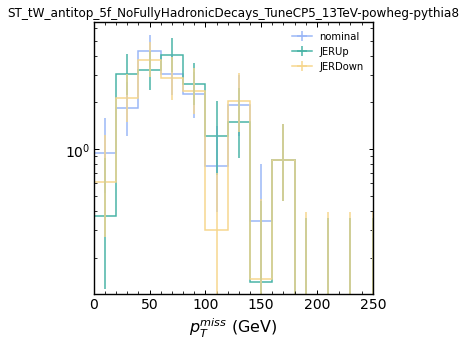

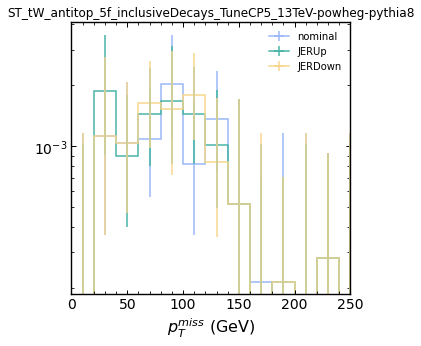

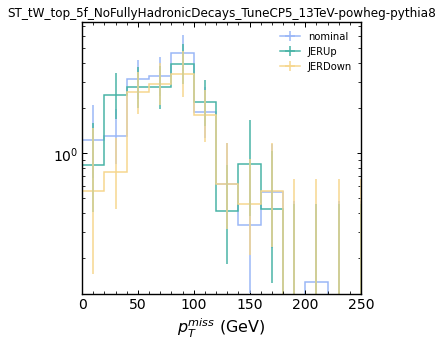

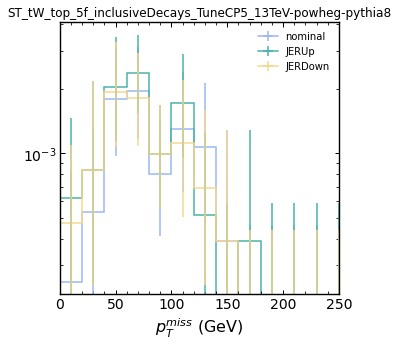

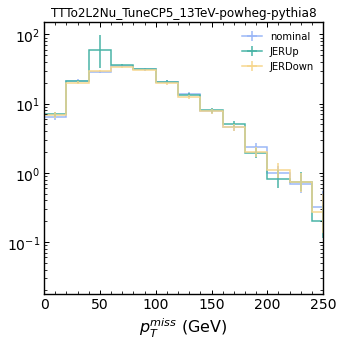

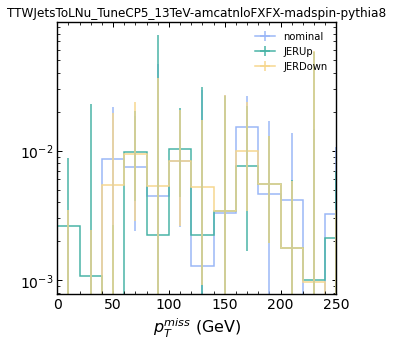

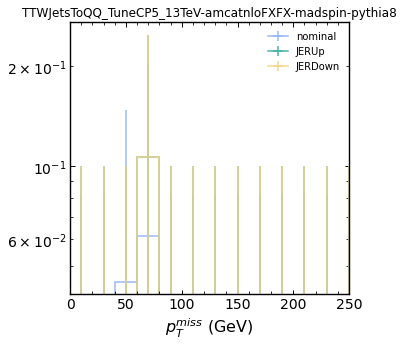

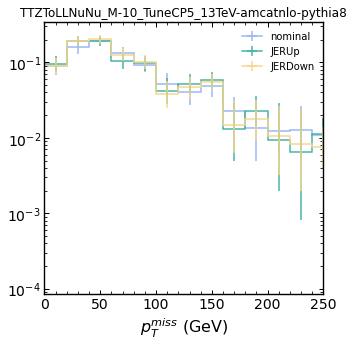

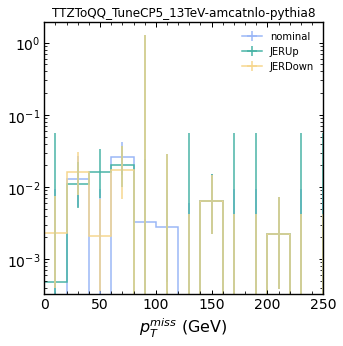

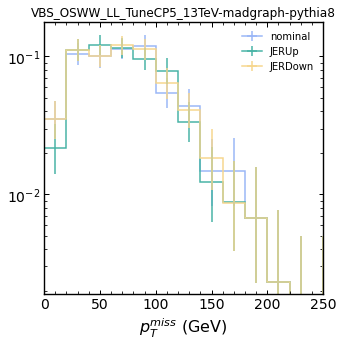

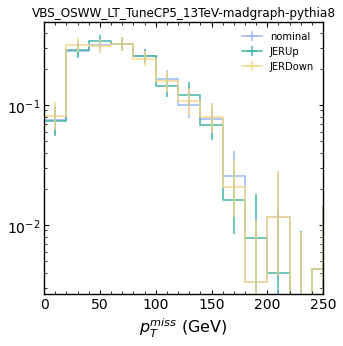

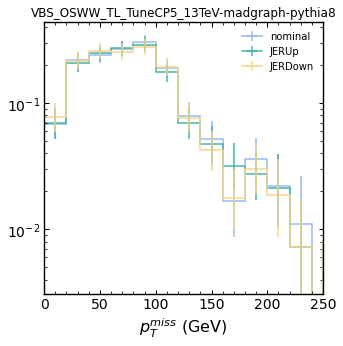

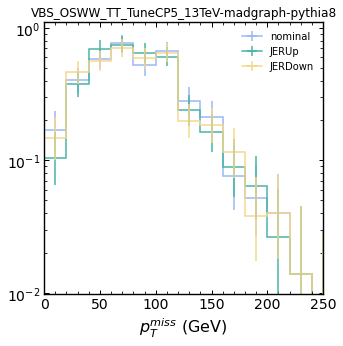

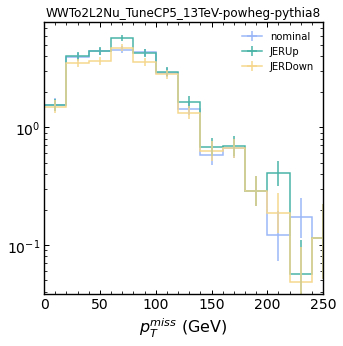

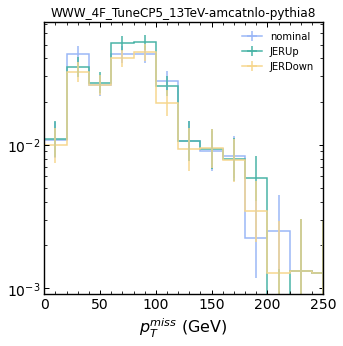

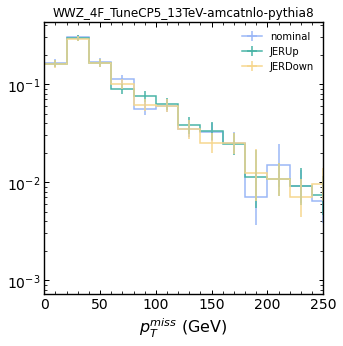

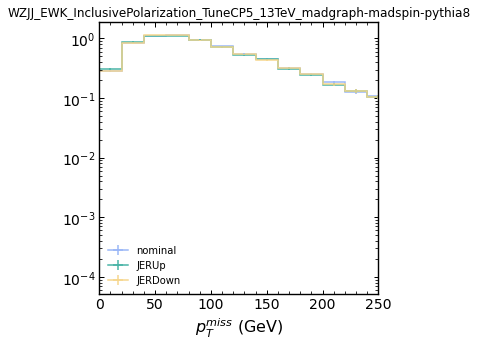

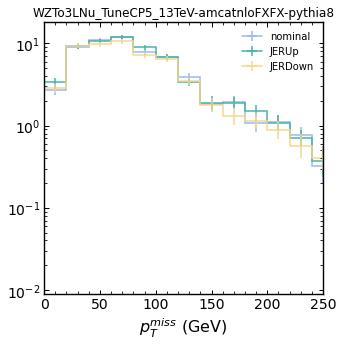

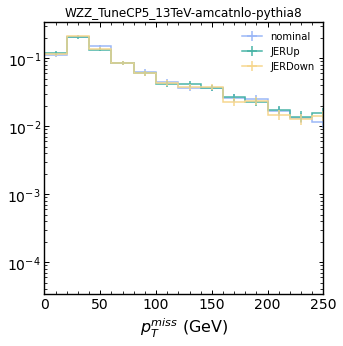

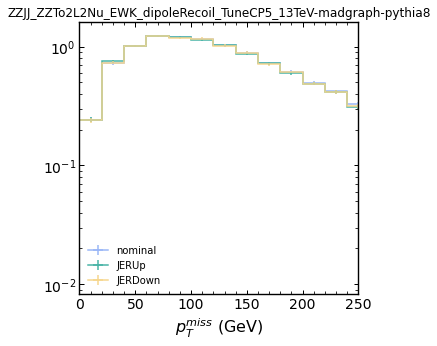

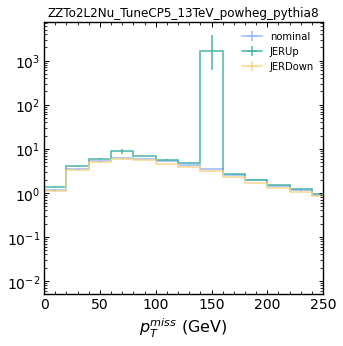

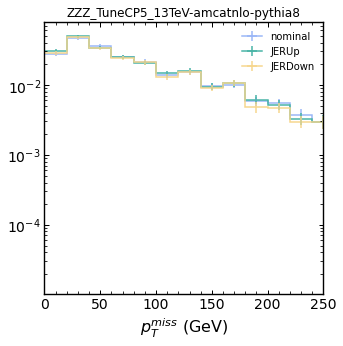

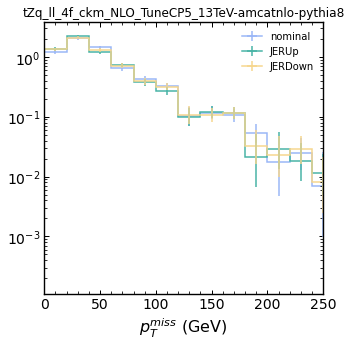

In [23]:
name = "DYJetsToLL_LHEFilterPtZ-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
# name = "DYJetsToLL_LHEFilterPtZ-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
# name = "DYJetsToLL_LHEFilterPtZ-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
# name = "DYJetsToLL_LHEFilterPtZ-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
# name = "DYJetsToLL_LHEFilterPtZ-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
# name = "DYJetsToLL_LHEFilterPtZ-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"

# name = "WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"
# name = "EWKZ2Jets_ZToLL_M-50_TuneCP5_withDipoleRecoil_13TeV-madgraph-pythia8"

# name = "ZZJJ_ZZTo2L2Nu_EWK_dipoleRecoil_TuneCP5_13TeV-madgraph-pythia8"

for name in config_2018.boosthist.keys():
    if name in ['DoubleMuon', "MuonEG", "SingleMuon", "EGamma"]: continue
    h = config_2018.boosthist[name]["hist"]["met_pt"]

    xsec  = 1.0
    xsec *= xsec_[name].get("xsec")
    xsec *= xsec_[name].get("kr")
    xsec *= xsec_[name].get("br")
    xsec *= 1000.0 

    sumw = config_2018.boosthist[name]["sumw"]
    norm = xsec * lumi/sumw

    np.set_printoptions(precision=2)
    print("-----------------------------------------")
    print(name, sumw, xsec_[name].get("xsec"), norm)
    try:
        plt.figure(figsize=(5,5))
        plt.title(name)
        for s in range(h.axes['systematic'].size):
            if ('nominal' not in h.axes['systematic'].value(s)) and  ('JER' not in h.axes['systematic'].value(s)): 
                continue
            (h[{
                "channel":"vbs-SR",
                "systematic":h.axes['systematic'].value(s), 
                "met_pt": hist.rebin(2)}
            ]*norm).plot(histtype='step', label=h.axes['systematic'].value(s))

            v = np.array(
                h[{
                    "channel":"vbs-SR", 
                    "systematic":h.axes['systematic'].value(s), 
                    "met_pt": hist.rebin(2)
                  }].values(0)*norm
            ).astype(np.float64)

            print([np.round(vv) for vv in v][0:10], h.axes['systematic'].value(s))
        plt.xlim([0,250])
        plt.yscale('log')
        plt.legend()
    except:
        print(name, " : not in in the axes")